In [130]:
# Last changed 18/11/2025

import sys
import glob
import os
import re
import pandas as pd
import statsmodels.api as sm
import matplotlib.pyplot as plt
from matplotlib.lines import Line2D
from matplotlib.ticker import FuncFormatter, MaxNLocator
import numpy as np
from datetime import datetime
from typing import Dict, Optional, List
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [131]:
# ╔═════════════════════════════╗
# ║ ✏️ VA CLIENT REQUIREMENTS   ║

client_id = "anita_chu"
budget = [4_000, 11_000]
year = 2000                     # Newer than or equal to
odo = [50, 250]                 # Odometer between
model_short = "yaris"
model_name = "Toyota Yaris"
n_shortlisted = 10              # Number of shortlisted cars

# ╚═════════════════════════════╝

## Market Analysis

In [132]:
# ---------- Constants ----------
YEAR_MIN, YEAR_MAX = 1980, 2035
ORDER: List[str] = ['href', 'year_make_model', 'trim', "listed_price", 'transmission', 'odometer', 'seller_type']

YEAR_RE  = r'\b(19[89]\d|20[0-3]\d)\b'
PRICE_RE = r'^\s*\$\s*[\d,]+(?:\.\d{2})?\b'
ODOM_RE  = r'^\s*\d{1,3}(?:,\d{3})+\s*km\s*$'
URL_RE   = r'^(?:https?://|www\.)'
TX, SELLER = {'automatic', 'manual'}, {'private', 'dealer used'}

THRESH: Dict[str, float] = {
    'year_make_model': 0.50,
    "listed_price":           0.60,
    'transmission':    0.80,
    'odometer':        0.60,
    'seller_type':     0.70,
}

# ---------- Predicates ----------
def _ratio(mask: pd.Series) -> float:
    return float(mask.mean()) if len(mask) else 0.0

def _yr_ok(s: pd.Series) -> pd.Series:
    years = pd.to_numeric(s.astype(str).str.extract(YEAR_RE, expand=False), errors='coerce')
    return years.between(YEAR_MIN, YEAR_MAX)

PRED = {
    'year_make_model': lambda s: s.astype(str).pipe(_yr_ok) & s.astype(str).str.contains(r'[A-Za-z]', na=False),
    "listed_price":           lambda s: s.astype(str).str.match(PRICE_RE, na=False),
    'transmission':    lambda s: s.astype(str).str.strip().str.lower().isin(TX),
    'odometer':        lambda s: s.astype(str).str.match(ODOM_RE, flags=re.I, na=False),
    'seller_type':     lambda s: s.astype(str).str.strip().str.lower().isin(SELLER),
}

# ---------- Core ----------
def identify_columns(df: pd.DataFrame) -> Dict[str, Optional[str]]:
    """Identify and map each canonical column."""
    cols = list(df.columns)
    if not cols:
        return {k: None for k in ORDER}

    href_col = cols[0]

    # exclude URL-like columns from other detection
    url_ratio = {c: _ratio(df[c].astype(str).str.contains(URL_RE, case=False, na=False)) for c in cols}
    urlish = {c for c, r in url_ratio.items() if r >= 0.50}
    blocked = {href_col} | urlish

    remaining = [c for c in cols if c not in blocked]
    picks = {t: None for t in PRED}

    for t in PRED:
        if not remaining:
            break
        scores = {c: _ratio(PRED[t](df[c])) for c in remaining}
        best_col, best_score = max(scores.items(), key=lambda kv: kv[1])
        if best_score >= THRESH[t]:
            picks[t] = best_col
            remaining.remove(best_col)

    trim_col = None
    ymm = picks.get('year_make_model')
    if ymm in cols:
        i = cols.index(ymm)
        if i + 1 < len(cols):
            trim_col = cols[i + 1]

    return {'href': href_col, **picks, 'trim': trim_col}

# ---------- Cleaning ----------
def clean_and_rename_cs(df: pd.DataFrame) -> pd.DataFrame:
    """Detect, rename, clean numeric/text data, and return standardized columns."""
    mapping = identify_columns(df)
    out = pd.DataFrame()

    # Map columns
    if mapping['href'] is not None:
        out['href'] = df[mapping['href']]
    for col in ['year_make_model', 'trim', "listed_price", 'transmission', 'odometer', 'seller_type']:
        src = mapping.get(col)
        if src is not None:
            out[col] = df[src]

    # Split "year make model"
    if 'year_make_model' in out.columns:
        split_cols = out['year_make_model'].astype(str).str.split(expand=True, n=2)
        split_cols.columns = ['year', 'make', 'model']
        out = pd.concat([out, split_cols], axis=1)

    # Clean hrefs (remove query strings)
    if 'href' in out.columns:
        out['href'] = out['href'].astype(str).str.split('?').str[0]

    # Clean numeric columns
    for col in ["listed_price", 'odometer']:
        if col in out.columns:
            out[col] = (
                out[col].astype(str)
                .replace('[^\\d]', '', regex=True)
                .replace('', pd.NA)
                .astype(float)
                .astype('Int64')
            )

    # Convert odometer to thousands of km
    if 'odometer' in out.columns:
        out['odometer'] = out['odometer'] // 1000

    # Add scrape date
    out['date_scraped'] = datetime.today().date()

    # Build final tidy table
    final_cols = ['href', 'year', 'make', 'model', "listed_price", 'trim', 'odometer', 'seller_type', 'date_scraped']
    return out[[c for c in final_cols if c in out.columns]]

In [133]:
# Reading all carsales csvs
# path = os.path.join(os.getcwd(), client_id)
path = ""
files = glob.glob(os.path.join(path, "carsales*.csv"))
cs = pd.concat([clean_and_rename_cs(pd.read_csv(f)) for f in files], ignore_index=True)
for f in files:
    print(f"{f} - {len(pd.read_csv(f))} listings.")

# Dropping duplicates
cs['href'] = cs['href'].astype(str)
print(f"{len(cs)} carsales listings total.")

# ╔═════════════════════════════╗
# ║    🔎 VA TO CHECK OUTPUT    ║

# 1. Check the following columns exist and entries is correct.
# href, year, make, model, price, trim, odometer, seller_type

# ╚═════════════════════════════╝

carsales (2).csv - 21 listings.
carsales (1).csv - 8 listings.
carsales.csv - 11 listings.
40 carsales listings total.


In [134]:
def clean_fb(df):
    # Split the b column into 'year', 'make', 'model'
    df[['year', 'make', 'model']] = df['b'].str.split(expand=True, n=2)



    # Rename columns
    rename_columns = {
        "x1i10hfl href": "href",
        "a": "listed_price",
        "c": "location",
        "d": "odometer",
    }

    # If marketplace scrape does not have column "c"
    if "c" not in df.columns:
      df["c"] = "NA"

    df.rename(columns=rename_columns, inplace=True)


    # removing query string
    df["href"] = df['href'].str.split('?').str[0]

    # Convert price and odometer columns to integers
    df=df[df["listed_price"]!="Free"]
    df["listed_price"] = df["listed_price"].replace(r'[^\d]', '', regex=True).astype(float).astype('Int64')
    df['odometer'] = df['odometer'].replace(r'[^\d]', '', regex=True).astype(float).astype('Int64')

    # Add a column with today's date
    df['date_scraped'] = datetime.today().date()

    # Removing listings with null values
    df = df.dropna(subset=["listed_price","odometer","year"])

    # Remove crashed listings
    df=df[df["listed_price"]!=12345]

    # Select only the required columns in order
    final_columns = ['href', 'year', 'make', 'model', "listed_price", 'odometer', 'location', 'date_scraped']
    df = df[final_columns]
    return df

In [135]:
files = glob.glob(os.path.join(path, "facebook*.csv"))
fb = pd.concat([clean_fb(pd.read_csv(f)) for f in files], ignore_index=True)

fb['href'] = fb['href'].astype(str)
before = len(fb)
print(f"Rows total {len(fb)}.")
fb = fb.drop_duplicates(subset=['href'], keep='first')
print(f"Rows no dups {len(fb)}.")

fb.head(5)

# ╔═════════════════════════════╗
# ║    🔎 VA TO CHECK OUTPUT    ║

# Ignore error if there's no FB Marketplace files
# 1. Check the following columns exist and entries is correct.
# href, year, make, model, price, location (NA is fine)

# ╚═════════════════════════════╝

Rows starting 89.
Rows remaining 76.


,href,year,make,model,listed_price,odometer,location,date_scraped
0,https://www.facebook.com/marketplace/item/6945...,2006,Toyota,yaris,3700,267,"Sydney, NSW",2025-11-27
1,https://www.facebook.com/marketplace/item/8697...,2011,Toyota,yaris,13900,69,"Sydney, NSW",2025-11-27
2,https://www.facebook.com/marketplace/item/3087...,2007,Toyota,yaris,3500,320,"Sydney, NSW",2025-11-27
3,https://www.facebook.com/marketplace/item/5055...,2006,Toyota,yaris,6000,201,"Sydney, NSW",2025-11-27
4,https://www.facebook.com/marketplace/item/1239...,2014,Toyota,yaris,180,97,"Sydney, NSW",2025-11-27


In [94]:
# ╔═════════════════════════════╗
# ║    ✏️ VA DATA SOURCE        ║

# Put a "#" infront of the code to stop it from running.

# Run this for Carsales only
# df = cs

# Run this for FB Marketplace only
# df = fb

# Run this for both Carsales and FB Marketplace
df = pd.concat([cs, fb], ignore_index=True)

# ╚═════════════════════════════╝

# Remove duplicates for cars in both carsales/fb marketplace
try:
    print(f"Carsales rows: {len(cs)}")
except NameError:
    pass
try:
    print(f"FB rows: {len(fb)}")
except NameError:
    pass

print(f"Merged Rows: {len(df)}")

dupes = df[df.duplicated(subset=['year', "listed_price", 'odometer'], keep=False)]
print(f"Duplicates:{len(dupes)}")


# ╔═════════════════════════════╗
# ║    🔎 VA TO CHECK OUTPUT    ║

# Does the number of rows after append match the input datasets?

# ╚═════════════════════════════╝

Carsales rows: 73
FB rows: 83
Merged Rows: 156
Duplicates:10


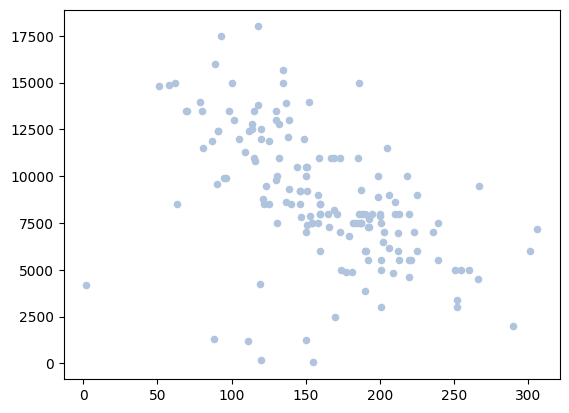

In [95]:
plt.scatter(df['odometer'], df["listed_price"], label='Data', color='lightsteelblue', s=20)

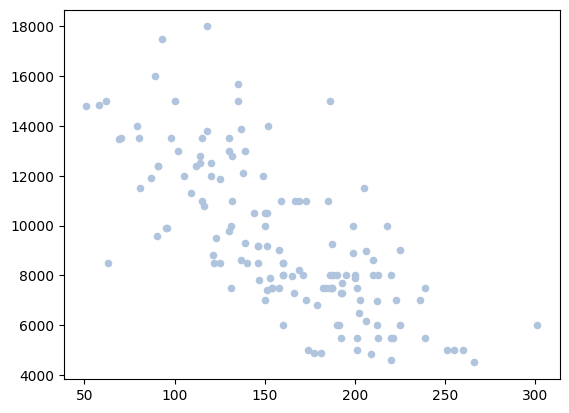

In [96]:
df1 = df
# ╔═════════════════════════════╗
# ║  ✏️ VA REMOVING OUTLIERS    ║

#
# NOTE TO FIEL AND KIM
# I changed the logic so that it
# removes according to the condition
# instead of keeps to the condition
# Please drop me a message if it doesn't make sense


# Removing listings with unrealistic low price
df1 = df1[~(df1["listed_price"]<4000)]

# Remove listings with high odometer
# df1 = df1[~(df1["odometer"]>270)]

# Remove listings with unrealistic low odometer
# df1 = df1[~(df1["odometer"]<30)]

# Custom keep: Remove listings where odometer < 150 AND price > 5000
df1 = df1[~(
    (df1["odometer"]<150) &
     (df1["listed_price"]<5000)
     )]

df1 = df1[~(
    (df1["odometer"]>250) &
     (df1["listed_price"]>6000)
     )]


# ╚═════════════════════════════╝

plt.scatter(df1['odometer'], df1["listed_price"], label='Data', color='lightsteelblue', s=20)
# Save file
# df.to_csv(f"{path}/{model_short}_all.csv", index=False)
df1.to_csv(f"/content/drive/Shareddrives/data/market_analysis/{client_id}_{model_short}.csv", index=False)

In [97]:
# 0) Work on a real copy (kills SettingWithCopyWarning)
df1 = df1.copy()

# 1) Coerce to numeric (allow bad cells to become NaN)
df1['year']     = pd.to_numeric(df1['year'], errors='coerce')
df1['odometer'] = pd.to_numeric(df1['odometer'], errors='coerce')
df1["listed_price"]    = pd.to_numeric(df1["listed_price"], errors='coerce')
df1['age'] = 2026 - df1['year']

# 2) Build X, y as float and drop rows with NaNs
X_num = df1[['age','odometer']].astype(float)
y_num = df1["listed_price"].astype(float)
keep  = X_num.notna().all(axis=1) & y_num.notna()

X = sm.add_constant(X_num.loc[keep])
y = y_num.loc[keep]

# Optional sanity checks
assert np.isfinite(X.to_numpy()).all() and np.isfinite(y.to_numpy()).all()
assert X[['age','odometer']].std().gt(0).all()

# 3) Fit and predict
model = sm.OLS(y, X).fit()
print(model.summary())

df1.loc[keep, 'predicted_price'] = model.predict(X)
df1.loc[keep, 'value_diff'] = df1.loc[keep, 'predicted_price'] - df1.loc[keep, "listed_price"]

print(f"Used {keep.sum()} rows; dropped {len(df1) - keep.sum()} rows.")


# ╔═════════════════════════════╗
# ║  ✏️ VA TO SAVE PARAMETERS   ║

# Save parameters in client/current_search (sheets)
# Column "coef"
# Row "const"
# Row "age"
# Row "odometer"

# ╚═════════════════════════════╝


                            OLS Regression Results                            
Dep. Variable:           listed_price   R-squared:                       0.620
Model:                            OLS   Adj. R-squared:                  0.615
Method:                 Least Squares   F-statistic:                     112.7
Date:                Wed, 26 Nov 2025   Prob (F-statistic):           9.62e-30
Time:                        23:49:17   Log-Likelihood:                -1262.5
No. Observations:                 141   AIC:                             2531.
Df Residuals:                     138   BIC:                             2540.
Df Model:                           2                                         
Covariance Type:            nonrobust                                         
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
const       2.644e+04   1831.838     14.432      0.0

In [98]:
# Identify n best value cars
within_crit = df1[
    (df1["listed_price"]<budget[1]) & (df1["listed_price"]>budget[0])
    & (df1['year']>=year)
    & (df1['odometer']<odo[1]) & (df1['odometer']>odo[0])
]

In [99]:
# Rank the top-n best-value cars (1 = best)
best_n = within_crit.sort_values('value_diff', ascending=False).head(n_shortlisted).copy()
best_n['rank'] = np.arange(1, len(best_n) + 1)


other_listings = df1.merge(best_n, how="outer", on='href',  indicator=True) \
          .query('_merge == "left_only"') \
          .drop(columns="_merge")

In [100]:
for _, row in best_n.iterrows():
    print(f"{model_name}\t{row['href']}\t{row['year']}\t{row['odometer']}\t{row["listed_price"]}")

#     print(f"{model_name} {row['rank']}")
#     print(f"Link: {row['href']}")
#     print(f"Price: ${row["listed_price"]:,}")
#     print(f"Market Value: ${row['predicted_price']:,.0f}")
#     print(f"Year: {row['year']:.0f}")
#     print(f"Odometer: {row['odometer']:,.0f},000km\n")
# Make Model	Link	Year	Odo	Listed Price
#
# ╔═════════════════════════════╗
# ║    🔎 VA TO VET LISTINGS    ║
# ╚═════════════════════════════╝
# Vetted listings go under
# clients/client_name [tab: Market Analysis]

Mazda 3	https://www.carsales.com.au/cars/details/2009-mazda-3-maxx-sport-bl-series-1-auto/SSE-AD-19772655/	2009	63	8500
Mazda 3	https://www.facebook.com/marketplace/item/2868219363568213/	2013	154	7500
Mazda 3	https://www.facebook.com/marketplace/item/1209394721003228/	2011	160	6000
Mazda 3	https://www.facebook.com/marketplace/item/749872691421604/	2012	201	5000
Mazda 3	https://www.facebook.com/marketplace/item/883279584232873/	2013	137	8599
Mazda 3	https://www.facebook.com/marketplace/item/644558025393799/	2012	209	4850
Mazda 3	https://www.facebook.com/marketplace/item/857596707222806/	2010	181	4900
Mazda 3	https://www.carsales.com.au/cars/details/2012-mazda-3-neo-bl-series-2-auto/SSE-AD-18941188/	2012	220	4596
Mazda 3	https://www.carsales.com.au/cars/details/2012-mazda-3-neo-bl-series-2-auto-my13/SSE-AD-19768600/	2012	158	7500
Mazda 3	https://www.carsales.com.au/cars/details/2011-mazda-3-neo-bl-series-2-auto/SSE-AD-19565639/	2011	192	5500


## Shortlist For Client

In [114]:
# Reading in [client_id]_[model_short].csv
df1 = pd.read_csv(f"/content/drive/Shareddrives/data/market_analysis/{client_id}_{model_short}.csv")
df1["nego_price"] = pd.NA
df1.head()

# ╔═════════════════════════════╗
# ║    🔎 VA TO CHECK OUTPUT    ║

# 1. Check the following columns exist and entries is correct.
# href, year, make, model, price, trim, odometer, seller_type

# ╚═════════════════════════════╝


,href,year,make,model,listed_price,trim,odometer,seller_type,date_scraped,location,nego_price
0,https://www.carsales.com.au/cars/details/2013-...,2013,Mazda,3,8900,Neo Auto F MY13,199,Private,2025-11-26,NaN,<NA>
1,https://www.carsales.com.au/cars/details/2011-...,2011,Mazda,3,7500,SP25 Auto F MY10,201,Private,2025-11-26,NaN,<NA>
2,https://www.carsales.com.au/cars/details/2012-...,2012,Mazda,3,8200,SP25 Auto F,169,Private,2025-11-26,NaN,<NA>
3,https://www.carsales.com.au/cars/details/2009-...,2009,Mazda,3,7990,Neo Auto F,165,Dealer used,2025-11-26,NaN,<NA>
4,https://www.carsales.com.au/cars/details/2011-...,2011,Mazda,3,7499,Neo Auto F,239,Private,2025-11-26,NaN,<NA>


In [102]:
# ╔═════════════════════════════════╗
# ║ ✏️ VA TO ADD NEGOTIATED PRICE   ║

hrefs=[
    # "https://www.facebook.com/marketplace/item/1209394721003228/",
    # "https://www.carsales.com.au/cars/details/2018-lexus-is-is300-luxury-auto/OAG-AD-25237260/",
]

nego_prices=[
    # 5000,
    # 28000,
]
# ╚═════════════════════════════════╝
for href, nego_price in zip(hrefs, nego_prices):
    mask = df1["href"] == href
    if mask.any():
        df1.loc[mask, "nego_price"] = nego_price
        print(f"nego_price added {href}")
    else:
        print(f"Listing not found {href}")

In [124]:
# ╔═════════════════════════════════╗
# ║ ✏️ VA TO ADD LISTINGS IF NEEDED ║

df1.loc[len(df1)] = {
    "href": "https://www.facebook.com/marketplace/item/1383543986451789/",
    "year": 2009,
    "make": "Mazda",
    "model": "3",
    "listed_price": 5200,
    # "nego_price": 23000,
    "odometer": 203,
}

# df1.loc[len(df1)] = {
#     "href": "https://www.carsales.com.au/cars/details/mazda-3-2010/sse-ad-19644655/",
#     "year": 2010,
#     "make": "Mazda",
#     "model": "3",
#     "listed_price": 8500,
#     # "nego_price": 23000,
#     "odometer": 122,
# }

# ╚═════════════════════════════════╝

In [125]:
# Building Regression Model
# 0) Work on a real copy (kills SettingWithCopyWarning)
df1 = df1.copy()

# 1) Coerce to numeric (allow bad cells to become NaN)
df1['year']     = pd.to_numeric(df1['year'], errors='coerce')
df1['odometer'] = pd.to_numeric(df1['odometer'], errors='coerce')
df1["listed_price"]    = pd.to_numeric(df1["listed_price"], errors='coerce')
df1['age'] = 2026 - df1['year']

# 2) Build X, y as float and drop rows with NaNs
X_num = df1[['age','odometer']].astype(float)
y_num = df1["listed_price"].astype(float)
keep  = X_num.notna().all(axis=1) & y_num.notna()

X = sm.add_constant(X_num.loc[keep])
y = y_num.loc[keep]

# Optional sanity checks
assert np.isfinite(X.to_numpy()).all() and np.isfinite(y.to_numpy()).all()
assert X[['age','odometer']].std().gt(0).all()

# 3) Fit and predict
model = sm.OLS(y, X).fit()
print(model.summary())

df1.loc[keep, 'predicted_price'] = model.predict(X)
df1.loc[keep, 'value_diff'] = df1.loc[keep, 'predicted_price'] - df1.loc[keep, "listed_price"]

print(f"Used {keep.sum()} rows; dropped {len(df1) - keep.sum()} rows.")

                            OLS Regression Results                            
Dep. Variable:           listed_price   R-squared:                       0.625
Model:                            OLS   Adj. R-squared:                  0.619
Method:                 Least Squares   F-statistic:                     115.7
Date:                Wed, 26 Nov 2025   Prob (F-statistic):           2.62e-30
Time:                        23:59:58   Log-Likelihood:                -1271.1
No. Observations:                 142   AIC:                             2548.
Df Residuals:                     139   BIC:                             2557.
Df Model:                           2                                         
Covariance Type:            nonrobust                                         
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
const       2.655e+04   1811.673     14.657      0.0

In [126]:
# ╔═════════════════════════════════╗
# ║ ✏️ VA TO PASTE SHORLIST HREFS   ║

listing_ids = ["sse-ad-19644655", "790068114200008", "1383543986451789"]
specific_cars = df1[df1["href"].str.contains("|".join(listing_ids), case=False, na=False)]

# ╚═════════════════════════════════╝

nego_cars = df1[df1["nego_price"].notna()]
within_crit = pd.concat([specific_cars, nego_cars])

In [127]:
# Rank the top-n best-value cars (1 = best)
best_n = within_crit.sort_values('value_diff', ascending=False).copy()
best_n['rank'] = np.arange(1, len(best_n) + 1)

other_listings = df1.merge(best_n, how="outer", indicator=True) \
          .query('_merge == "left_only"') \
          .drop(columns="_merge")

In [128]:
for _, row in best_n.iterrows():
    print(f"{model_name} {row['rank']}")
    print(f"Link: {row['href']}")
    print(f"Market Value: ${row['predicted_price']:,.0f}")
    print(f"Listed Price: ${row["listed_price"]:,}")
    try:
        print(f"Negotiated Price: ${row['nego_price']:,.0f}")
    except KeyError as e:
        pass
    print(f"Year: {row['year']:.0f}")
    print(f"Odometer: {row['odometer']:,.0f},000km")
    print(f"Notes:\n")

Mazda 3 1
Link: https://www.carsales.com.au/cars/details/2010-mazda-3-neo-bl-series-1-auto-my10/SSE-AD-19644655/
Market Value: $10,300
Listed Price: $8,500
Negotiated Price: $nan
Year: 2010
Odometer: 122,000km
Notes:

Mazda 3 2
Link: https://www.facebook.com/marketplace/item/1383543986451789/
Market Value: $6,127
Listed Price: $5,200
Negotiated Price: $nan
Year: 2009
Odometer: 203,000km
Notes:

Mazda 3 3
Link: https://www.facebook.com/marketplace/item/790068114200008/
Market Value: $9,656
Listed Price: $8,800
Negotiated Price: $nan
Year: 2009
Odometer: 121,000km
Notes:



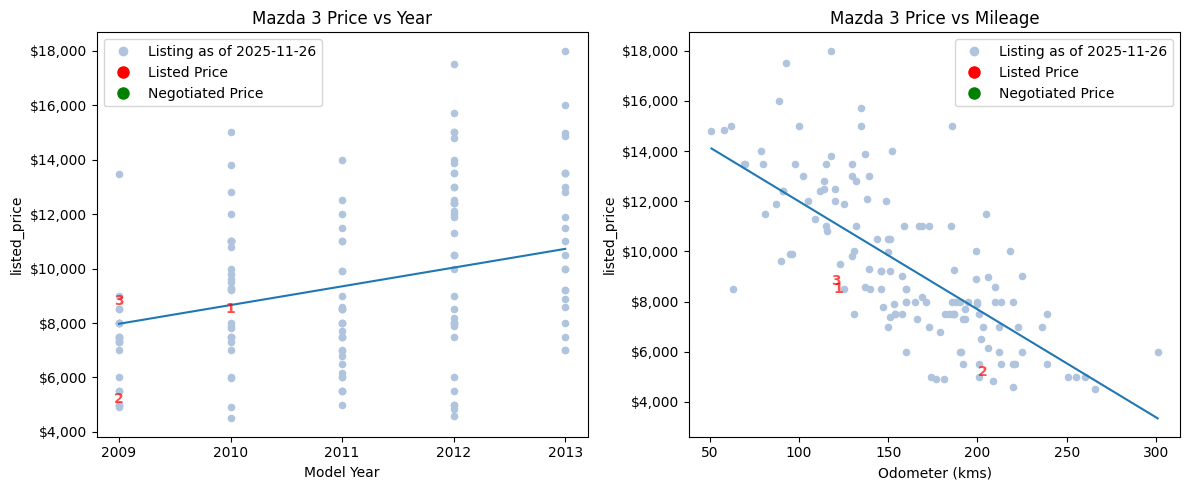

In [129]:
# Function to format price axis
def price_format(x, _):
    return f'${int(x):,}'

# Plotting
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(12, 5))

# Compute age
other_listings['age'] = 2026 - other_listings['year']
best_n['age'] = 2026 - best_n['year']

# Scatter (Year vs Price)
ax1.scatter(other_listings['year'], other_listings["listed_price"],
            label='Data', color='lightsteelblue', s=20)

for _, row in best_n.iterrows():
    ax1.scatter(row['year'], row["listed_price"], s=70, facecolors='none', linewidths=1.2)
    ax1.text(row['year'], row["listed_price"], str(int(row['rank'])),
             ha='center', va='center', fontsize=10, fontweight='bold',
             color='red', alpha=0.7)
    if not pd.isna(row['nego_price']):
        ax1.text(row['year'], row['nego_price'], str(int(row['rank'])),
                 ha='center', va='center', fontsize=10, fontweight='bold',
                 color='green', alpha=0.7)

# Regression line (fix odometer at mean)
year_range = np.linspace(other_listings['year'].min(),
                         other_listings['year'].max(), 100)

age_range = 2026 - year_range  # convert back to age for model input
mean_odometer = other_listings['odometer'].mean()

X_line = pd.DataFrame({
    'const': 1,
    'age': age_range,
    'odometer': [mean_odometer] * 100
})

y_line = model.predict(X_line)

ax1.plot(year_range, y_line, label='Regression line')

ax1.xaxis.set_major_locator(MaxNLocator(integer=True))
ax1.yaxis.set_major_formatter(FuncFormatter(price_format))
ax1.set_xlabel('Model Year')
ax1.set_ylabel("listed_price")
ax1.set_title(f"{model_name} Price vs Year")

# Scatter (Odometer vs Price)
ax2.scatter(other_listings['odometer'], other_listings["listed_price"],
            label='Data', color='lightsteelblue', s=20)

for _, row in best_n.iterrows():
    ax2.scatter(row['odometer'], row["listed_price"], s=70, facecolors='none', linewidths=1.2)
    ax2.text(row['odometer'], row["listed_price"], str(int(row['rank'])),
             ha='center', va='center', fontsize=10, fontweight='bold',
             color='red', alpha=0.7)
    if not pd.isna(row['nego_price']):
        ax2.text(row['odometer'], row['nego_price'], str(int(row['rank'])),
                 ha='center', va='center', fontsize=10, fontweight='bold',
                 color='green', alpha=0.7)

# Regression line (fix age at mean)
odometer_range = np.linspace(other_listings['odometer'].min(),
                             other_listings['odometer'].max(), 100)

mean_age = other_listings['age'].mean()

X_line2 = pd.DataFrame({
    'const': 1,
    'age': [mean_age] * 100,
    'odometer': odometer_range
})

y_line2 = model.predict(X_line2)
ax2.plot(odometer_range, y_line2, label='Regression line')

ax2.yaxis.set_major_formatter(FuncFormatter(price_format))
ax2.set_xlabel('Odometer (kms)')
ax2.set_ylabel("listed_price")
ax2.set_title(f"{model_name} Price vs Mileage")


# Legend handles
live_listing_handle = Line2D([], [], marker='o', color='lightsteelblue', linestyle='None', markersize=6, label=f'Listing as of {df1.iloc[0]["date_scraped"]}')
listed_price_handle = Line2D([], [], marker='o', color='red', linestyle='None',
                                 markersize=8, label='Listed Price')
negotiated_price_handle = Line2D([], [], marker='o', color='green', linestyle='None',
                                 markersize=8, label='Negotiated Price')

# Apply legend to both subplots
ax1.legend(handles=[live_listing_handle, listed_price_handle, negotiated_price_handle])
ax2.legend(handles=[live_listing_handle, listed_price_handle, negotiated_price_handle])


plt.tight_layout()
plt.show()